In [ ]:
import pandas as pd
import numpy as np
import itertools

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from sklearn.model_selection import learning_curve, train_test_split, StratifiedKFold, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from imblearn.pipeline import Pipeline as ImbPipeline

from scipy.stats import loguniform, uniform

from imblearn.over_sampling import SMOTE, RandomOverSampler

import matplotlib.pyplot as plt
import warnings

# Suppress all warnings for cleaner output
warnings.filterwarnings('ignore')

## 1. Dataset Loading

Loading the data and dropping the id column since it does not contain usefull information.

In [76]:
df = pd.read_csv('data.csv')
X = df.drop(['id', 'stroke'], axis=1)
y = df['stroke']

## 2. Exploratory Data Analysis (EDA) and Missing Value Analysis

In [33]:
print("Original Dataset Head:")
df.head()

Original Dataset Head:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [34]:
print("\nDataset shape:", X.shape)


Dataset shape: (1501, 10)


In [35]:
print("Target variable distribution (0: no stroke, 1: stroke):\n", y.value_counts())

Target variable distribution (0: no stroke, 1: stroke):
 stroke
0    1252
1     249
Name: count, dtype: int64


In [36]:
print(f"Stroke percentage: {y.value_counts(normalize=True)[1]:.2%}")

Stroke percentage: 16.59%


In [77]:
print("Dataset Info:")
X.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1501 entries, 0 to 1500
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             1501 non-null   object 
 1   age                1501 non-null   float64
 2   hypertension       1501 non-null   int64  
 3   heart_disease      1501 non-null   int64  
 4   ever_married       1501 non-null   object 
 5   work_type          1501 non-null   object 
 6   Residence_type     1501 non-null   object 
 7   avg_glucose_level  1501 non-null   float64
 8   bmi                1423 non-null   float64
 9   smoking_status     1501 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 117.4+ KB


In [38]:
print("\nDescriptive Statistics for Numerical Features:")
X.describe()


Descriptive Statistics for Numerical Features:


,age,hypertension,heart_disease,avg_glucose_level,bmi
count,1501.000000,1501.000000,1501.000000,1501.000000,1423.000000
mean,46.269500,0.117921,0.068621,110.086829,29.401335
std,23.051721,0.322622,0.252893,48.207092,7.829511
min,0.240000,0.000000,0.000000,55.220000,12.000000
25%,28.000000,0.000000,0.000000,78.400000,24.100000
50%,49.000000,0.000000,0.000000,93.880000,28.400000
75%,65.000000,0.000000,0.000000,119.010000,33.600000
max,82.000000,1.000000,1.000000,271.740000,78.000000


In [ ]:
print("\nPercentage of missing values per column:")
missing_percentages = X.isnull().sum(axis=0) / X.shape[0]
print(missing_percentages[missing_percentages > 0])


Percentage of missing values per column:
bmi    0.051965
dtype: float64


## 3. Definition of the Data Transformation Pipeline

In [78]:
numerical_features = ['age', 'avg_glucose_level', 'bmi']
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Pipeline for numerical features: Imputation (for 'bmi') and Scaling
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())
])

# Pipeline for categorical features: Imputation (if any) and One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # For any potential missing categorical values
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # 'ignore' new categories in test set
])

In [79]:
# Create a ColumnTransformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop', # Drop columns not specified
    verbose_feature_names_out=False # To get clean feature names out of OneHotEncoder
)

print("Data transformation pipelines defined.")

Data transformation pipelines defined.


# 4. Training and Test Sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print(f"Training target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test target distribution:\n{y_test.value_counts(normalize=True)}")

Training set shape: (1200, 10), Test set shape: (301, 10)
Training target distribution:
stroke
0    0.834167
1    0.165833
Name: proportion, dtype: float64
Test target distribution:
stroke
0    0.833887
1    0.166113
Name: proportion, dtype: float64


Initial pipeline structure for nested cross-validation.
Placeholder classifier that will be tuned by RandomizedSearchCV.

In [ ]:
model_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', SMOTE()),
    ('dim_reduction', PCA(n_components=0.8)),
    ('classifier', Perceptron())
])

Sanity check, to ensure pipeline is working as expected.

In [ ]:
print("\nSanity check for initial pipeline:")
try:
    model_pipeline.fit(X_train, y_train)
    _ = model_pipeline.predict(X_test)
    print("Initial pipeline fit and predict successful.")
except Exception as e:
    print(f"Error during initial pipeline sanity check: {e}")


Sanity check for initial pipeline:
Initial pipeline fit and predict successful.


hyperparameter configurations for different classifiers

In [ ]:
sampler_configs = [
    {
        'sampler':[None],
    },
    {
        'sampler':[SMOTE()],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
    {
        'dim_reduction': [LDA()]
    }
]


classifier_configs = [
    {
        'classifier__eta0' : loguniform(0.001,100),
        'classifier': [Perceptron()] ,
        'classifier__max_iter': [1,5,10,15,50,100] ,
        'classifier__class_weight' : [None, 'balanced']

    },
    {
        'classifier': [LogisticRegression(solver='saga')],
        'classifier__C' : loguniform(0.001,100),
        'classifier__penalty': ['l1','l2'],
        'classifier__class_weight' : [None, 'balanced']

    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3,5,7,9]
    },
    {
        'classifier' : [RandomForestClassifier()],
        'classifier__n_estimators' : [10,50,100, 500]
    }
]

Generate all possible configurations by simply appending classifier_configs.

In [ ]:
all_configs = []
for sampler_config, dim_reduction_config, classifier_config in itertools.product(sampler_configs, dim_reduction_configs, classifier_configs):
    combined_config = {}
    combined_config.update(sampler_config)
    combined_config.update(dim_reduction_config)
    combined_config.update(classifier_config)
    all_configs.append(combined_config)

print(f"\nNumber of different base classifier configurations for RandomizedSearchCV: {len(all_configs)}")


Number of different base classifier configurations for RandomizedSearchCV: 36


RandomizedSearchCV for the inner loop

In [ ]:
rs = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 4, 
    n_jobs=-1, 
    cv=2,
    scoring='f1',
    random_state=42,
)

In [ ]:
scores = cross_validate(rs, X_train, y_train,
                        scoring='f1',
                        cv=5,
                        return_estimator=True,
                        verbose=3,
                        n_jobs=-1)

print("\nNested cross-validation complete.")
print("Cross-validation F1-scores for each fold:", scores['test_score']) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.

Nested cross-validation complete.
Cross-validation F1-scores for each fold: [0.55932203 0.57142857 0.544      0.49253731 0.51282051]



# 6. Evaluation of Best Candidates

In [49]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

None
None
LogisticRegression(C=np.float64(0.45151576288430445), class_weight='balanced',
                   solver='saga') {'C': np.float64(0.45151576288430445), 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
0.559322033898305
----------
RandomOverSampler(sampling_strategy=0.9)
LinearDiscriminantAnalysis()
LogisticRegression(C=np.float64(0.05628491809848934), solver='saga') {'C': np.float64(0.05628491809848934), 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
0.5714285714285714
----------
None
None
LogisticRegression(C=np.float64(95.77860311

# 7. Refinement of the Selected Model


In [ ]:
# Select the overall best estimator based on mean test_score
best_overall_f1_idx = np.argmax(scores['test_score'])
best_overall_estimator_pipeline = scores['estimator'][best_overall_f1_idx].best_estimator_

In [57]:
# Get the type of the best classifier for targeted refinement
best_classifier_type = type(best_overall_estimator_pipeline.named_steps['classifier'])
print(f"Refining model based on the best performing classifier from nested CV: {best_classifier_type.__name__}")

Refining model based on the best performing classifier from nested CV: LogisticRegression


In [64]:
# Define a specific pipeline for refinement using the structure and best classifier found
refined_model_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', RandomOverSampler()),
    ('dim_reduction', LDA()),
    ('classifier', LogisticRegression(solver='saga', penalty = 'l1'))
])

In [65]:
# Define a narrower parameter search space for refinement based on the best classifier's type
refinement_params = {
    'classifier__C': [0.04, 0.05, 0.06],
    'sampler__sampling_strategy': ['minority', 0.85, 0.9, 0.95]
}

In [68]:
rs_best = RandomizedSearchCV(
    estimator=refined_model_pipeline,
    param_distributions=refinement_params,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42),
    n_iter=100,
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=1
)
rs_best.fit(X_train, y_train)

print(f"\nBest parameters after refinement: {rs_best.best_params_}")
print(f"Best F1 score after refinement (on CV folds): {rs_best.best_score_:.4f}")
final_best_model = rs_best.best_estimator_

Fitting 15 folds for each of 12 candidates, totalling 180 fits

Best parameters after refinement: {'sampler__sampling_strategy': 0.9, 'classifier__C': 0.06}
Best F1 score after refinement (on CV folds): 0.5400


# 8. Final Evaluation and Visualization


In [69]:
y_test_pred_final = final_best_model.predict(X_test)
final_accuracy_score = accuracy_score(y_test, y_test_pred_final)
final_precision_score = precision_score(y_test, y_test_pred_final)
final_recall_score = recall_score(y_test, y_test_pred_final)
final_f1_score = f1_score(y_test, y_test_pred_final)
final_roc_auc_score = roc_auc_score(y_test, final_best_model.predict_proba(X_test)[:, 1])

print(f"Final Accuracy Score on the held-out test set: {final_accuracy_score:.4f}")
print(f"Final Precision Score on the held-out test set: {final_precision_score:.4f}")
print(f"Final Recall Score on the held-out test set: {final_recall_score:.4f}")
print(f"Final F1-score on the held-out test set: {final_f1_score:.4f}")
print(f"Final ROC AUC score on the held-out test set: {final_roc_auc_score:.4f}")

Final Accuracy Score on the held-out test set: 0.7309
Final Precision Score on the held-out test set: 0.3434
Final Recall Score on the held-out test set: 0.6800
Final F1-score on the held-out test set: 0.4564
Final ROC AUC score on the held-out test set: 0.8280


In [ ]:
probabilities = final_best_model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 1.0, 0.05) # Test a range of thresholds
for t in thresholds:
    y_pred_threshold = (probabilities >= t).astype(int)
    prec = precision_score(y_test, y_pred_threshold)
    rec = recall_score(y_test, y_pred_threshold)
    f1 = f1_score(y_test, y_pred_threshold)
    print(f"Threshold: {t:.2f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1-Score: {f1:.4f}")


Threshold: 0.10 | Precision: 0.2092 | Recall: 1.0000 | F1-Score: 0.3460
Threshold: 0.15 | Precision: 0.2439 | Recall: 1.0000 | F1-Score: 0.3922
Threshold: 0.20 | Precision: 0.2688 | Recall: 1.0000 | F1-Score: 0.4237
Threshold: 0.25 | Precision: 0.2800 | Recall: 0.9800 | F1-Score: 0.4356
Threshold: 0.30 | Precision: 0.2885 | Recall: 0.9000 | F1-Score: 0.4369
Threshold: 0.35 | Precision: 0.3143 | Recall: 0.8800 | F1-Score: 0.4632
Threshold: 0.40 | Precision: 0.3226 | Recall: 0.8000 | F1-Score: 0.4598
Threshold: 0.45 | Precision: 0.3246 | Recall: 0.7400 | F1-Score: 0.4512
Threshold: 0.50 | Precision: 0.3434 | Recall: 0.6800 | F1-Score: 0.4564
Threshold: 0.55 | Precision: 0.3951 | Recall: 0.6400 | F1-Score: 0.4885
Threshold: 0.60 | Precision: 0.4189 | Recall: 0.6200 | F1-Score: 0.5000
Threshold: 0.65 | Precision: 0.4154 | Recall: 0.5400 | F1-Score: 0.4696
Threshold: 0.70 | Precision: 0.5417 | Recall: 0.5200 | F1-Score: 0.5306
Threshold: 0.75 | Precision: 0.5676 | Recall: 0.4200 | F1-Score:

In [73]:
y_test_pred_final_threshold = (probabilities >= 0.6).astype(int)


Confusion Matrix for the Final Model:


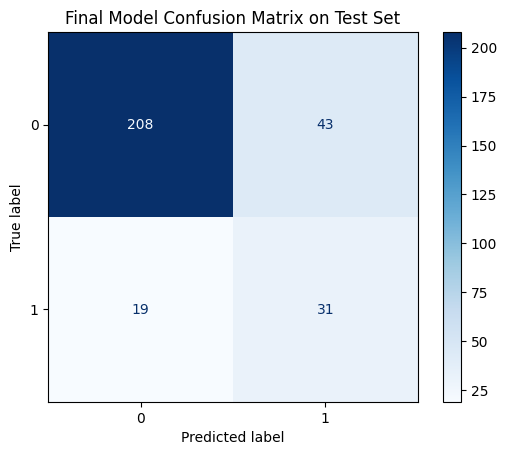

In [74]:
# Confusion Matrix for the final model
print("\nConfusion Matrix for the Final Model:")
cm_final = confusion_matrix(y_test, y_test_pred_final_threshold, labels=final_best_model.classes_)
disp_final = ConfusionMatrixDisplay(confusion_matrix=cm_final, display_labels=final_best_model.classes_)
disp_final.plot(cmap=plt.cm.Blues)
plt.title("Final Model Confusion Matrix on Test Set")
plt.show()



Generating Learning Curve...


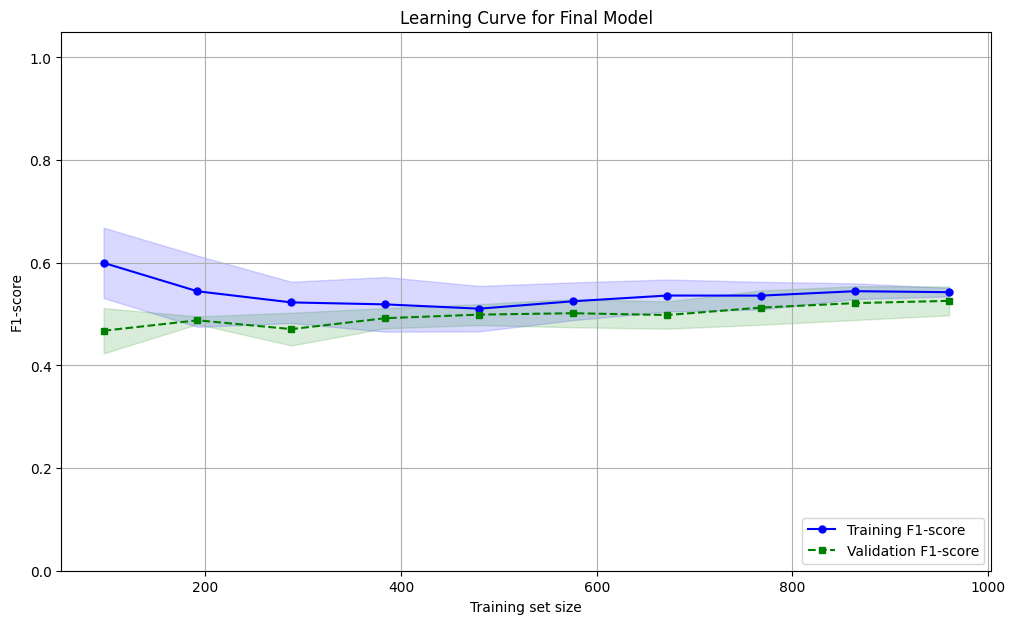

In [ ]:

print("\nGenerating Learning Curve...")
train_sizes, train_scores, test_scores = learning_curve(
    final_best_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    scoring='f1',
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12, 7))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training F1-score')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation F1-score')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Training set size')
plt.ylabel('F1-score')
plt.title('Learning Curve for Final Model')
plt.legend(loc='lower right')
plt.ylim([0.0, 1.05])
plt.show()